# Exploring `dataset_fire_wind_aligned.npy`


## Libraries & Modules


In [2]:
from datetime import datetime, timedelta # Added for potential timestamp generation
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml


## Configuration


In [11]:
notebook_dir = Path().absolute()
project_root = notebook_dir.parent
raw_data_dir = project_root / 'data' / 'raw'

# Define file paths using the / operator with Path objects
main_data_file = raw_data_dir / 'pm25gnn' / 'data' / 'dataset_fire_wind_aligned.npy'
location_file = raw_data_dir / 'locations.txt'
config_file = project_root / 'pm25_forecasting_gnn' / 'config.yaml' # Using the main config

## Load Data

In [8]:
print(f"Loading main data from: {main_data_file}")
try:
    # Load the main dataset (Time x Location x Features+PM2.5)
    # np.load works directly with Path objects
    raw_data = np.load(main_data_file)
    print(f"Successfully loaded {main_data_file}")
except FileNotFoundError:
    print(f"ERROR: Main data file not found at {main_data_file}")
    print("Please ensure the file exists and the 'data_dir' path is correct.")
    exit()
except Exception as e:
    print(f"ERROR: Could not load {main_data_file}. Reason: {e}")
    exit()

print(f"\nLoading location info from: {location_file}")
try:
    # Load location data (ID, City, Lat, Lon)
    # pd.read_csv works directly with Path objects
    locations_df = pd.read_csv(
        location_file,
        sep=' ',
        header=None,
        names=['location_id', 'city', 'latitude', 'longitude']
    )
    # Use location_id as index, ensure it matches the data dimension order
    locations_df = locations_df.set_index('location_id')
    # Sort by index if needed, assuming the raw_data's location dimension
    # corresponds to sorted location IDs (0 to N-1)
    locations_df = locations_df.sort_index()
    location_names = locations_df['city'].tolist()
    num_locations_from_file = len(location_names)
    print(f"Successfully loaded {location_file}")
except FileNotFoundError:
    print(f"ERROR: Location file not found at {location_file}")
    # Create placeholder names based on the dimension size from the loaded data
    location_names = [f"Loc_{i}" for i in range(raw_data.shape[1])]
    num_locations_from_file = 0 # Mark as not loaded
    print(f"Using placeholder location names: {location_names}")
except Exception as e:
    print(f"ERROR: Could not load {location_file}. Reason: {e}")
    location_names = [f"Loc_{i}" for i in range(raw_data.shape[1])]
    num_locations_from_file = 0 # Mark as not loaded
    print(f"Using placeholder location names: {location_names}")


print(f"\nLoading configuration from: {config_file}")
try:
    # open() works directly with Path objects
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    # Extract feature names from the config file
    # These correspond to the features *before* PM2.5
    feature_names = config['data']['metero_var']
    print(f"Successfully loaded {config_file}")
except FileNotFoundError:
    print(f"ERROR: Config file not found at {config_file}")
    # Create placeholder names based on the dimension size from the loaded data
    feature_names = [f"Feat_{i}" for i in range(raw_data.shape[2] - 1)]
    print(f"Using placeholder feature names: {feature_names}")
except KeyError:
     print(f"ERROR: 'data: metero_var' key not found in {config_file}")
     feature_names = [f"Feat_{i}" for i in range(raw_data.shape[2] - 1)]
     print(f"Using placeholder feature names: {feature_names}")
except Exception as e:
    print(f"ERROR: Could not load {config_file}. Reason: {e}")
    feature_names = [f"Feat_{i}" for i in range(raw_data.shape[2] - 1)]
    print(f"Using placeholder feature names: {feature_names}")

# Combine feature names with PM2.5
all_col_names = feature_names + ['PM25']

Loading main data from: /home/jon/ds-capstone/data/raw/pm25gnn/data/dataset_fire_wind_aligned.npy
Successfully loaded /home/jon/ds-capstone/data/raw/pm25gnn/data/dataset_fire_wind_aligned.npy

Loading location info from: /home/jon/ds-capstone/data/raw/locations.txt
Successfully loaded /home/jon/ds-capstone/data/raw/locations.txt

Loading configuration from: /home/jon/ds-capstone/pm25_forecasting_gnn/config.yaml
Successfully loaded /home/jon/ds-capstone/pm25_forecasting_gnn/config.yaml


## Initial Inspection

In [9]:
print("\n--- Initial Data Inspection ---")
num_time_steps, num_locations, num_features_pm25 = raw_data.shape
print(f"Raw data shape: {raw_data.shape}")
print(f"  Number of time steps: {num_time_steps}")
print(f"  Number of locations: {num_locations}")
print(f"  Number of features + PM2.5: {num_features_pm25}")



--- Initial Data Inspection ---
Raw data shape: (43816, 112, 18)
  Number of time steps: 43816
  Number of locations: 112
  Number of features + PM2.5: 18


### Validate Dimensions

In [10]:
if num_locations_from_file > 0 and num_locations_from_file != num_locations:
    print(f"WARNING: Number of locations in data ({num_locations}) "
          f"does not match locations in file ({num_locations_from_file}). Check location file or data.")
if len(all_col_names) != num_features_pm25:
     print(f"WARNING: Number of column names ({len(all_col_names)}) "
           f"does not match feature dimension in data ({num_features_pm25}). Check config file or data.")
     # Adjust column names if mismatch (e.g., due to missing config)
     if len(all_col_names) < num_features_pm25:
         missing_cols = num_features_pm25 - len(all_col_names)
         all_col_names.extend([f"Unknown_{i+1}" for i in range(missing_cols)])
     else: # If more names than features, truncate names
         all_col_names = all_col_names[:num_features_pm25]
     print(f"Adjusted column names used: {all_col_names}")

## Reshape and Convert to DataFrame

In [12]:
# This makes analysis easier but can be memory-intensive for very large datasets.
print("\n--- Reshaping Data for Analysis (using Pandas) ---")

# Create time index (assuming hourly data starting from a known point)
# NOTE: This start time is an *assumption* based on config files.
# You might need to load 'time_dict.pkl' or 'alltimes_pst.npy'
# for accurate timestamps if the NPY doesn't align perfectly or has gaps.
try:
    # Try getting start date from config (used in dataset.py)
    start_dt_list = config['dataset']['data_start'][0]
    # Ensure time components are handled correctly (hour is index 3)
    start_dt = datetime(start_dt_list[0], start_dt_list[1], start_dt_list[2], start_dt_list[3])
    print(f"Assuming data starts at: {start_dt} (from config)")
except (KeyError, TypeError, IndexError, ValueError): # Added ValueError for potential parsing issues
    start_dt = datetime(2017, 1, 1, 0) # Fallback assumption
    print(f"WARNING: Could not determine start time from config. Assuming {start_dt}.")

time_index = pd.date_range(start_dt, periods=num_time_steps, freq='h') # 'h' for hourly frequency

# Create MultiIndex for Pandas DataFrame (Time x Location)
multi_index = pd.MultiIndex.from_product([time_index, location_names], names=['Timestamp', 'Location'])

# Reshape the 3D NumPy array to 2D ( (Time*Location) x Features+PM2.5 )
# Ensure the reshape order matches the MultiIndex order (Time varies fastest)
reshaped_data = raw_data.reshape(-1, num_features_pm25)

# Create the DataFrame
df = pd.DataFrame(reshaped_data, index=multi_index, columns=all_col_names)

print("DataFrame head:")
print(df.head())
print("\nDataFrame info:")
df.info() # Provides non-null counts and dtypes



--- Reshaping Data for Analysis (using Pandas) ---
Assuming data starts at: 2017-01-01 01:00:00 (from config)
DataFrame head:
                              100m_u_component_of_wind  \
Timestamp           Location                             
2017-01-01 01:00:00 city0                     3.686647   
                    city1                     1.913737   
                    city2                     4.500641   
                    city3                     1.812227   
                    city4                     3.680901   

                              100m_v_component_of_wind  \
Timestamp           Location                             
2017-01-01 01:00:00 city0                    -2.550763   
                    city1                    -0.391165   
                    city2                     0.260641   
                    city3                     4.298872   
                    city4                    -2.429477   

                              2m_dewpoint_temperature  2m_t

## Missing Value Check

In [13]:
print("\n--- Missing Value Check ---")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing_values, 'Percentage': missing_percent})
print("Missing values per column:")
# Print only columns with missing values
print(missing_df[missing_df['Count'] > 0])
if missing_df['Count'].sum() == 0:
    print("No missing values found in the DataFrame.")
else:
    print("Consider imputation strategies (e.g., forward fill, interpolation, mean/median fill) based on the nature of the data.")


--- Missing Value Check ---
Missing values per column:
Empty DataFrame
Columns: [Count, Percentage]
Index: []
No missing values found in the DataFrame.


## Summary Statistics

In [14]:
print("\n--- Summary Statistics ---")
# Select key columns for summary (e.g., PM2.5 and a few features)
# Make sure the feature names actually exist in the derived `all_col_names`
cols_to_summarize = ['PM25'] + [name for name in feature_names[:3] if name in all_col_names]

if cols_to_summarize:
    print(f"Summary for columns: {cols_to_summarize}")
    # Use .astype(float) to handle potential non-numeric types if needed, though describe often handles this
    try:
        print(df[cols_to_summarize].astype(float).describe())
    except Exception as e:
        print(f"Could not generate statistics for all selected columns. Error: {e}")
        print("Attempting PM2.5 only:")
        try:
            print(df[['PM25']].astype(float).describe())
        except Exception as e_pm:
            print(f"Could not generate statistics for PM2.5. Error: {e_pm}")

else:
    print("No columns selected or found for summary statistics.")



--- Summary Statistics ---
Summary for columns: ['PM25', '100m_u_component_of_wind', '100m_v_component_of_wind', '2m_dewpoint_temperature']
               PM25  100m_u_component_of_wind  100m_v_component_of_wind  \
count  4.907392e+06              4.907392e+06              4.907392e+06   
mean   9.789763e+00              1.066738e+00              1.030201e-01   
std    1.508510e+01              2.555392e+00              2.886328e+00   
min   -3.820000e+01             -1.658856e+01             -1.557300e+01   
25%    4.000000e+00             -5.531425e-01             -1.626991e+00   
50%    7.000000e+00              1.084845e+00              1.766913e-01   
75%    1.200000e+01              2.701295e+00              1.772379e+00   
max    1.467200e+03              1.619644e+01              1.997189e+01   

       2m_dewpoint_temperature  
count             4.907392e+06  
mean              2.796994e+02  
std               6.701678e+00  
min               2.313567e+02  
25%               

## Basic Visualizations

### PM2.5 Distribution (Overall)

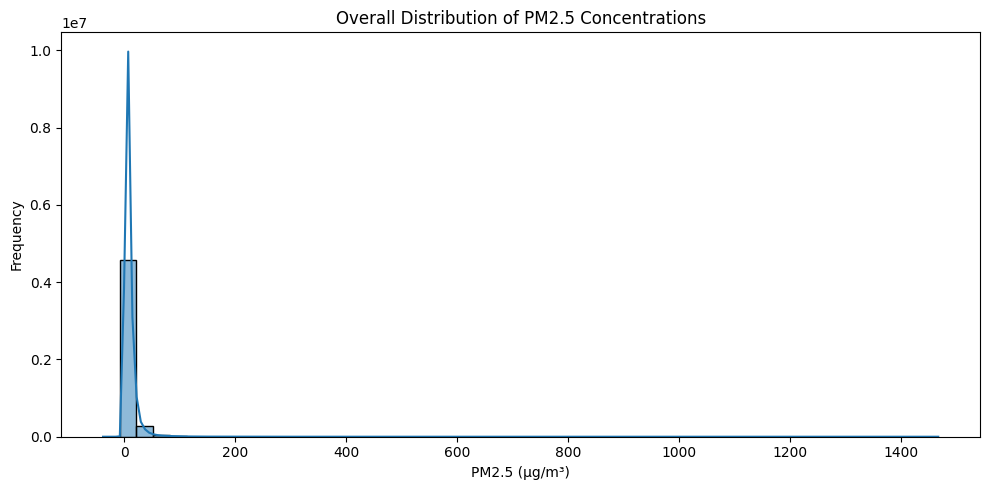

In [15]:
if 'PM25' in df.columns:
    plt.figure(figsize=(10, 5))
    # Use dropna() to avoid issues with potential NaNs during plotting
    sns.histplot(df['PM25'].dropna(), kde=True, bins=50)
    plt.title('Overall Distribution of PM2.5 Concentrations')
    plt.xlabel('PM2.5 (µg/m³)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping PM2.5 distribution plot (PM25 column not found).")

### 2. PM2.5 Boxplot per Location (Sample)


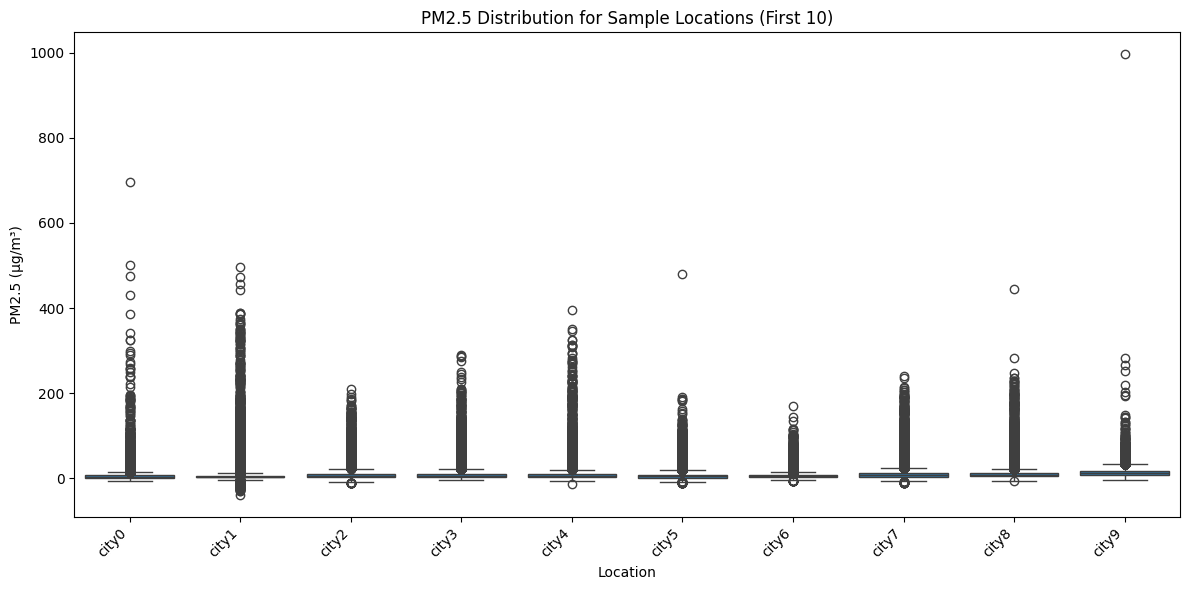

In [16]:
if 'PM25' in df.columns and location_names:
    # Select a subset of locations if there are too many
    num_locations_to_plot = min(10, num_locations)
    sample_locations = location_names[:num_locations_to_plot]

    # Filter DataFrame for sample locations using the index
    df_sample_locs = df[df.index.get_level_values('Location').isin(sample_locations)]

    plt.figure(figsize=(12, 6))
    # Use reset_index() only for plotting function if it requires flat columns
    sns.boxplot(data=df_sample_locs.reset_index(), x='Location', y='PM25')
    plt.title(f'PM2.5 Distribution for Sample Locations (First {num_locations_to_plot})')
    plt.xlabel('Location')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
     print("Skipping PM2.5 boxplot (PM25 column or location names not available).")

### 3. Time Series Plot (Single Location)

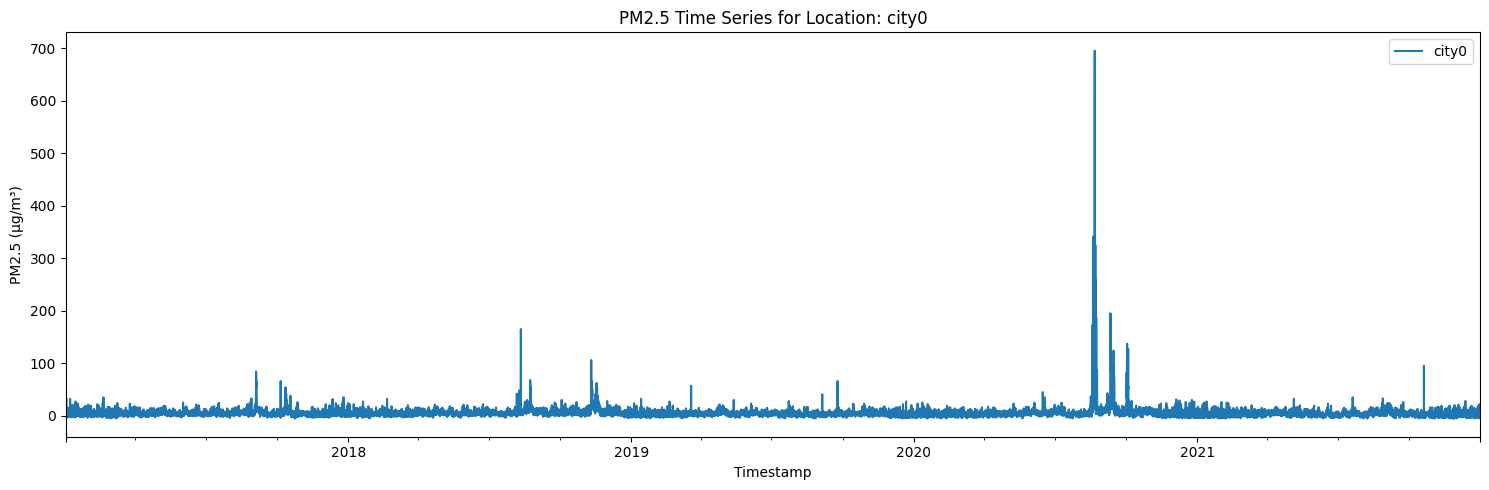

In [17]:
if 'PM25' in df.columns and location_names:
    first_location = location_names[0]
    plt.figure(figsize=(15, 5))
    try:
        # df.xs(key, level) allows selecting data for a specific location from MultiIndex
        df.xs(first_location, level='Location')['PM25'].plot(label=first_location)
        plt.title(f'PM2.5 Time Series for Location: {first_location}')
        plt.xlabel('Timestamp')
        plt.ylabel('PM2.5 (µg/m³)')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except KeyError:
        print(f"Could not plot time series for location '{first_location}'. It might not be in the DataFrame index.")
    except Exception as e:
         print(f"An error occurred plotting time series for {first_location}: {e}")

else:
    print("Skipping single location time series plot (PM25 column or location names not available).")